# Example Report Plotting Yield Curve

In [94]:
import importlib

In [151]:
import sys
sys.path.insert(0, '../')
from project_tools import pullers
from stdnum import cusip
import pandas as pd
from project_tools import plots

In [165]:
importlib.reload(plots)

<module 'project_tools.plots' from '/Users/collin/dev/test_repo/reports/../project_tools/plots.py'>

## Pull bond info and yields from WRDS

In [97]:
sql = """
WITH yld AS (SELECT caldt, tdnomprc, tdyld, tdduratn, kycrspid FROM crsp_m_treasuries.tfz_dly WHERE caldt = DATE('2025-01-15')), 
info as (SELECT tmatdt, kycrspid,tcusip FROM crsp_m_treasuries.tfz_iss) 
SELECT yld.*, info.* FROM yld 
LEFT JOIN info ON yld.kycrspid=info.kycrspid
"""

In [98]:
df_joined = pullers.pull_WRDS(sql = sql)

Loading library list...
Done


In [99]:
df_joined.head()

,caldt,tdnomprc,tdyld,tdduratn,kycrspid,tmatdt,kycrspid,tcusip
0,2025-01-15,101.72455,0.000105,206.070139,20250815.106870,2025-08-15,20250815.106870,912810EV
1,2025-01-15,94.753906,0.000132,4059.339151,20400515.104370,2040-05-15,20400515.104370,912810QH
2,2025-01-15,79.328125,0.000133,4604.602324,20420215.103120,2042-02-15,20420215.103120,912810QU
3,2025-01-15,73.037798,<NA>,<NA>,20430215.B00620,2043-02-15,20430215.B00620,912810RA
4,2025-01-15,83.929688,0.000134,4718.944639,20430815.103620,2043-08-15,20430815.103620,912810RC


## Compile CUSIPs to get auction data for

In [100]:
df_joined['cusip9'] = df_joined['tcusip'].apply(lambda x: x + cusip.calc_check_digit(x))

In [101]:
df_joined.head()

,caldt,tdnomprc,tdyld,tdduratn,kycrspid,tmatdt,kycrspid,tcusip,cusip9
0,2025-01-15,101.72455,0.000105,206.070139,20250815.106870,2025-08-15,20250815.106870,912810EV,912810EV6
1,2025-01-15,94.753906,0.000132,4059.339151,20400515.104370,2040-05-15,20400515.104370,912810QH,912810QH4
2,2025-01-15,79.328125,0.000133,4604.602324,20420215.103120,2042-02-15,20420215.103120,912810QU,912810QU5
3,2025-01-15,73.037798,<NA>,<NA>,20430215.B00620,2043-02-15,20430215.B00620,912810RA,912810RA8
4,2025-01-15,83.929688,0.000134,4718.944639,20430815.103620,2043-08-15,20430815.103620,912810RC,912810RC4


## Pull auction data for this CUSIPs

In [167]:
auctions = pullers.pull_TreasuryDirect_Auctions(cusips = df_joined['cusip9'].tolist())

In [103]:
auctions_keep = auctions.groupby('cusip')[['issueDate', 'maturityDate', 'type', 'originalSecurityTerm']].first().reset_index()
display(auctions_keep.head())

,cusip,issueDate,maturityDate,type,originalSecurityTerm
0,912797JR9,2024-12-12,2025-01-23,CMB,52-Week
1,912797KA4,2025-01-09,2025-02-20,CMB,52-Week
2,912797KJ5,2025-02-06,2025-03-20,CMB,52-Week
3,912797KS5,2025-03-06,2025-04-17,Bill,52-Week
4,912797LB1,2025-02-13,2025-05-15,Bill,52-Week


## Join with the CRSP data, and compile some derived stats

In [104]:
df_joined_sample = pd.merge(df_joined, auctions_keep, left_on='cusip9', right_on='cusip', validate='1:1', how='inner')

In [105]:
df_joined_sample['caldt'] = pd.to_datetime(df_joined_sample['caldt'])

In [127]:
df_joined_sample['till_mat'] = (df_joined_sample['maturityDate'] - df_joined_sample['caldt']).dt.days / 365
df_joined_sample['yld'] = df_joined_sample['tdyld'] * 100 * 365
df_joined_sample['dv01'] = (df_joined_sample['tdduratn'] / 365 * df_joined_sample['tdnomprc']/10000) / (1 + df_joined_sample['tdyld'] * 365 / 2)
display(df_joined_sample.head())

,caldt,tdnomprc,tdyld,tdduratn,kycrspid,tmatdt,kycrspid,tcusip,cusip9,cusip,issueDate,maturityDate,type,originalSecurityTerm,till_mat,yld,dv01
0,2025-01-15,101.72455,0.000105,206.070139,20250815.106870,2025-08-15,20250815.106870,912810EV,912810EV6,912810EV6,1995-08-15,2025-08-15,Bond,30-Year,0.580822,3.839007,0.005635
1,2025-01-15,94.753906,0.000132,4059.339151,20400515.104370,2040-05-15,20400515.104370,912810QH,912810QH4,912810QH4,2010-07-15,2040-05-15,Bond,30-Year,15.339726,4.803207,0.102909
2,2025-01-15,79.328125,0.000133,4604.602324,20420215.103120,2042-02-15,20420215.103120,912810QU,912810QU5,912810QU5,2012-04-16,2042-02-15,Bond,30-Year,17.095890,4.866197,0.097698
3,2025-01-15,73.037798,<NA>,<NA>,20430215.B00620,2043-02-15,20430215.B00620,912810RA,912810RA8,912810RA8,2013-10-31,2043-02-15,TIPS,30-Year,18.095890,<NA>,<NA>
4,2025-01-15,83.929688,0.000134,4718.944639,20430815.103620,2043-08-15,20430815.103620,912810RC,912810RC4,912810RC4,2013-10-15,2043-08-15,Bond,30-Year,18.591781,4.895717,0.105917


## Plot!

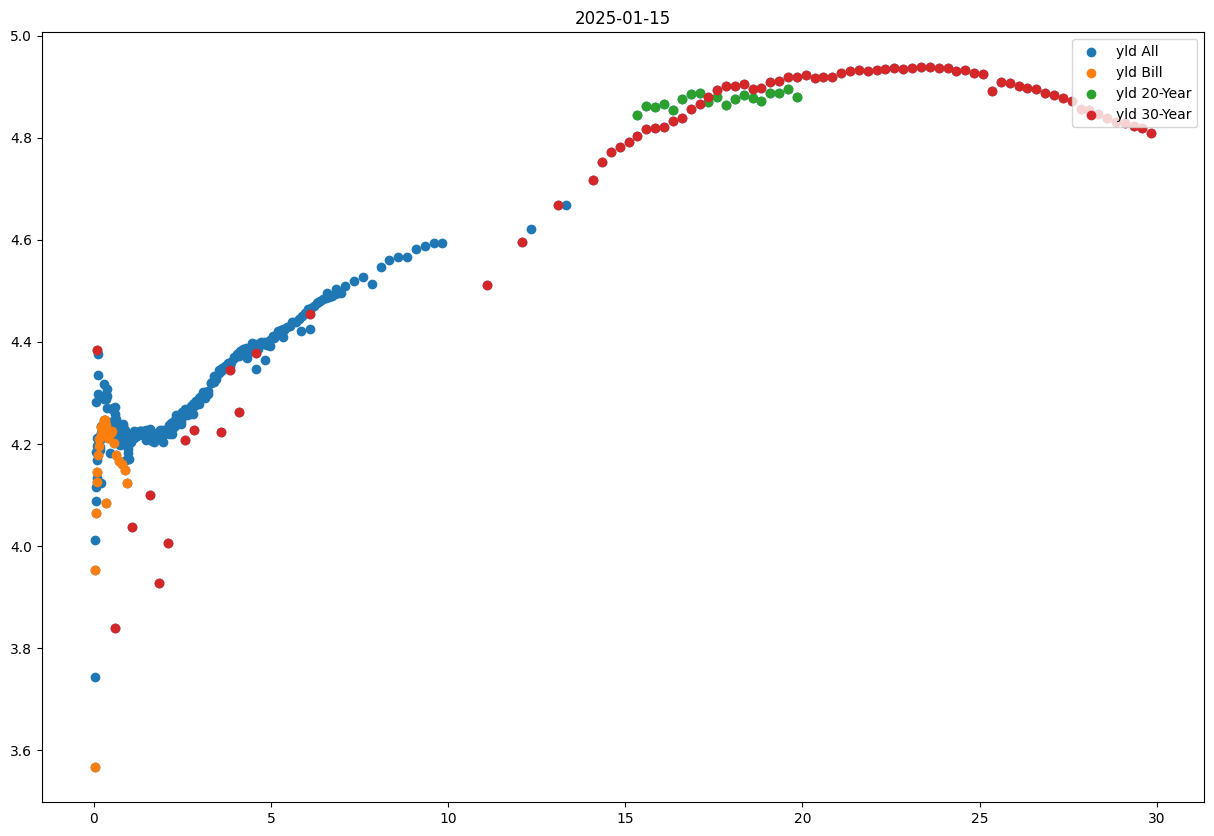

In [166]:
plots.plot_termstructure(df_joined_sample.loc[df_joined_sample['till_mat'] > 0.01, :], \
                         y=['yld'], dts_plot=['2025-01-15'], mat='till_mat', dt='caldt', \
                         term_sep=[('type','Bill'), \
                                   ('originalSecurityTerm','20-Year'), \
                                  ('originalSecurityTerm', '30-Year')], \
                        output=Path('/Users/collin/dev/test_repo/_output'), name = 'yld_20250115')